# Text Classification
(This notebook is created by [liyinnbw](https://github.com/liyinnbw/ML/tree/master/TextClassification) under the MIT license)

Problem Definition:
* Classify english news titles into one of the given topics.
* Assuming each news is associated with one and only one of the topics.



## Import Training & Testing Data
Instead of using provided dataset, you can also use your own dataset as long as the data contains a text column and a label column.

In [65]:
import pandas as pd

labelMeanings=['Ratings downgrade','Sanctions','Growth into new markets','New product coverage','Others']
col = ['title', 'category']
df_train = pd.read_csv('https://raw.githubusercontent.com/liyinnbw/ML/master/NewsClassification/Data/train.csv')[col]
df_test = pd.read_csv('https://raw.githubusercontent.com/liyinnbw/ML/master/NewsClassification/Data/test.csv')[col]

X_train = df_train.title
y_train = df_train.category
X_test = df_test.title
y_test = df_test.category

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)

df_train.head()

train shape: (6027,)
test shape: (3826,)


,title,category
0,Forex - Pound drops to one-month lows against ...,4
1,Hertz to Exit Equipment Rental Business in $2....,2
2,Gold ETF inflows return,4
3,"Hackers call Mt. Gox CEO a liar, say he still ...",4
4,Gold Climbs To Near 6-Month High On Concerns A...,4


## Data Preprocessing & Feature Extraction
* Replace numbers by common token
* Keep only letters
* Stemming (remove word tense)
* tf-idf feature extraction

The same preprocessing should be applied to test data.

Wrap the preprocessing inside a custom transformer which can be used inside a training pipeline.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

class CustomPreprocessor(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.tfidf = TfidfVectorizer(
            sublinear_tf=True, 
            min_df=1, 
            norm='l2', 
            strip_accents='ascii', 
            analyzer='word', 
            ngram_range=(1, 2), 
            stop_words= [
                'i', 'me', 'my', 'myself', 'we', 'our', 'our', 
                'ourselv', 'you', 'your', 'youv', 'youll', 'youd', 
                'your', 'your', 'yourself', 'yourselv', 'he', 'him', 
                'his', 'himself', 'she', 'shes', 'her', 'her', 
                'herself', 'it', 'it', 'it', 'itself', 'they', 'them', 
                'their', 'their', 'themselv', 'what', 'which', 'who', 
                'whom', 'this', 'that', 'thatll', 'these', 'those', 
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'be', 
                'have', 'has', 'had', 'have', 'do', 'doe', 'did', 
                'do', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                'becaus', 'as', 'until', 'while', 'of', 'at', 'by', 
                'for', 'with', 'about', 'against', 'between', 'into', 
                'through', 'dure', 'befor', 'after', 'abov', 'below', 
                'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 
                'over', 'under', 'again', 'further', 'then', 'onc', 
                'here', 'there', 'when', 'where', 'whi', 'how', 'all', 
                'ani', 'both', 'each', 'few', 'more', 'most', 'other', 
                'some', 'such', 'no', 'nor', 'not', 'onli', 'own', 
                'same', 'so', 'than', 'too', 'veri', 's', 't', 'can', 
                'will', 'just', 'don', 'dont', 'should', 'shouldv', 
                'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 
                'aren', 'arent', 'couldn', 'couldnt', 'didn', 'didnt', 
                'doesn', 'doesnt', 'hadn', 'hadnt', 'hasn', 'hasnt', 
                'haven', 'havent', 'isn', 'isnt', 'ma', 'mightn', 
                'mightnt', 'mustn', 'mustnt', 'needn', 'neednt', 
                'shan', 'shant', 'shouldn', 'shouldnt', 'wasn', 
                'wasnt', 'weren', 'werent', 'won', 'wont', 'wouldn', 
                'wouldnt', 'numtoken', 'again'
            ]
        )
    def clean(self, X):
        X_processed = X
        # replace numbers
        X_processed = X_processed.str.replace('\d*\.\d+|\d+', ' NUMTOKEN ', regex=True)
        # remove '
        X_processed = X_processed.str.replace("'", '', regex=False)
        # keep only letters
        X_processed = X_processed.str.replace('[^A-Za-z]+', ' ', regex=True)
        # stemming
        st = SnowballStemmer("english")
        X_processed = X_processed.apply(lambda row: row.split(" "))
        X_processed = X_processed.apply(lambda row: [st.stem(word) for word in row])
        X_processed = X_processed.apply(lambda row: " ".join(row))
        return X_processed
    def fit(self, X, y=None):
        # clean data
        X_processed = self.clean(X)
        # train tf-idf model
        self.tfidf.fit(X)
        return self
    def transform(self, X):
        # clean data
        X_processed = self.clean(X)
        # transform sentence to numerical vector using tf-idf
        X_processed = self.tfidf.transform(X_processed)
        return X_processed
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X,y)
        return self.transform(X)

In [67]:
prep = CustomPreprocessor()
x_train = prep.fit_transform(X_train)
x_test = prep.transform(X_test) 
print('train shape:', x_train.shape)
print('test shape:', x_test.shape)

train shape: (6027, 22822)
test shape: (3826, 22822)


## Training
Using training data only, cross-validated, compared across different model choices.

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score


models = [
    MultinomialNB(alpha=1.0, fit_prior=True),
    DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=0.1, min_samples_leaf=1, min_impurity_decrease=0, class_weight=None, random_state=27),
    LinearSVC(random_state=27, max_iter=1000),
    SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=27, max_iter=1000),
    LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=27, max_iter=1000),
    RandomForestClassifier(criterion='gini', max_depth=3, min_samples_split=0.1, min_samples_leaf=1, min_impurity_decrease=0, class_weight=None, n_estimators=100, random_state=27),
    GradientBoostingClassifier(criterion='friedman_mse', max_depth=3, min_samples_split=0.1, min_samples_leaf=1, min_impurity_decrease=0, n_estimators=100, random_state=27)
]
models.append(BaggingClassifier(models[0], n_estimators=100, random_state=27))
models.append(AdaBoostClassifier(models[0], algorithm="SAMME.R", n_estimators=100, random_state=27))


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


## Visualize Model Performances

[Text(0, 0, 'MultinomialNB'),
 Text(0, 0, 'DecisionTreeClassifier'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'SGDClassifier'),
 Text(0, 0, 'LogisticRegression'),
 Text(0, 0, 'RandomForestClassifier'),
 Text(0, 0, 'GradientBoostingClassifier'),
 Text(0, 0, 'BaggingClassifier'),
 Text(0, 0, 'AdaBoostClassifier')]

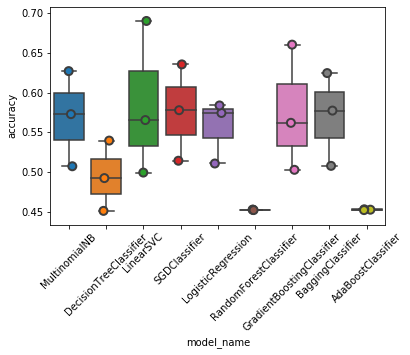

In [33]:
import seaborn as sns
chart = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

## Testing


In [55]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

for model in models:
    model_name = model.__class__.__name__
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    print(model_name)
    print(conf_mat)
    # report = metrics.classification_report(y_test, y_pred)
    # print(report)
    print("accuracy: {:0.5f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("f2: {:0.5f}".format(metrics.fbeta_score(y_pred, y_test, beta=2, average="macro")))


# import numpy as np
# labls = np.arange(5).tolist()
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(conf_mat, cmap=plt.cm.Blues, vmin=0)
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labls)
# ax.set_yticklabels([''] + labls)
# plt.xlabel('Predicted')
# plt.ylabel('Expected')
# plt.show()

MultinomialNB
[[ 465    0    3    0  232]
 [   0   48    0    0  203]
 [   0    0  666    0   61]
 [   0    0   26  175   72]
 [   2    0   96    6 1771]]
accuracy: 0.81678
f2: 0.79381
DecisionTreeClassifier
[[ 198    0    0    0  502]
 [   0    0    0    0  251]
 [   0    0  323    0  404]
 [   0    0    0  171  102]
 [   0    0    3    0 1872]]
accuracy: 0.67015
f2: 0.60044
LinearSVC
[[ 627    0   12    0   61]
 [   0  215    0    0   36]
 [   2    0  678    6   41]
 [   0    0    4  260    9]
 [  85   48  210   45 1487]]
accuracy: 0.85389
f2: 0.84562
SGDClassifier
[[ 603    0    0    0   97]
 [   0  194    0    0   57]
 [   0    0  694    6   27]
 [   0    0    5  258   10]
 [  58   21  104   11 1681]]
accuracy: 0.89650
f2: 0.89857
LogisticRegression
[[ 602    0    6    0   92]
 [   6  178    0    0   67]
 [   0    0  704    0   23]
 [   0    0    4  254   15]
 [  56   12  132   12 1663]]
accuracy: 0.88892
f2: 0.89520
RandomForestClassifier
[[   0    0    0    0  700]
 [   0    0   

## Problem1: Class Imbalance
There is an uneven distribution of labels in the training data known as the "Class Imbalance" problem. This problem can cause the trained model to sacrifice precision and recall on under-represented classes in favour of improving the precision and recall on over-represented classes (which is observed in the above testing results). This problem is common in real world where not all classes are observed evenly. You could:
1. Over sample under-represented classes to match up with the class that occurred most frequently (many repeated samples adversely affect the network decision).
2. Under sample the over-represented classes to match up with the class that occurred least frequently (waste of precious data).
3. Synthesize under-represented classes to match up with the class that occurred most frequently (design of synthesize algorithm is difficult).
4. Change the way you group classes (if allowed to).


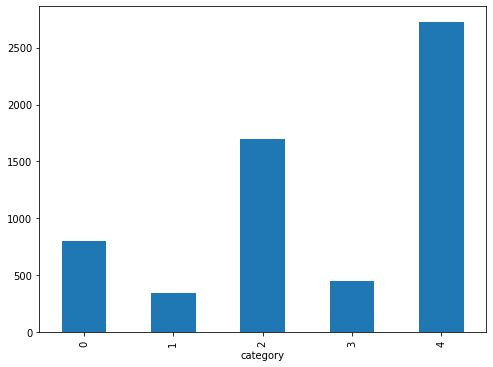

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_train.groupby('category').title.count().plot.bar(ylim=0)
plt.show()

## Problem2: Wrong Training Labels
It could happen that the training data obtained contains wrong labels. Usually these wrong labels are relatively few as compared to the correct ones. Hence we have a solution for it:

* We can use a simple clustering method to find news that are very similar in text but are given different labels. We can correct these wrong labels with high confidence by majority vote.

In [68]:
from sklearn.cluster import DBSCAN
import numpy as np

doc_lbls = DBSCAN(eps=0.03, min_samples=3, metric='cosine').fit_predict(x_train)
clusters = np.unique(doc_lbls)
print("# of clusters = ",len(clusters)-1)

# only relabel if >0.5 fraction of the data have same label
relable_percent_thresh = 0.5
# and only if majority label > 2 times the second majority label
relable_second_thresh = 2.0

y_train_corrected = y_train.copy()

for lbl in clusters:
    if lbl<0:
        # does not belong to any cluster
        continue
    X_cluster = X_train[doc_lbls==lbl]
    y_cluster = y_train_corrected[doc_lbls==lbl]
    binCounts = np.bincount(y_cluster)
    binMax = np.argmax(binCounts)
    binMaxCount = binCounts[binMax]
    binCounts[binMax] = 0
    binSecondMax = np.argmax(binCounts)
    binSecondMaxCount = binCounts[binSecondMax]
    if (binSecondMaxCount == 0):
        # print('consistent')
        continue
    elif binMaxCount*1.0/binSecondMaxCount>=relable_second_thresh and binMaxCount*1.0/len(X_cluster) >= relable_percent_thresh:
        y_train_corrected[doc_lbls==lbl] = binMax
        print(X_cluster)
        print('relabel to:', binMax)
    else:
        # print('cant decide')
        continue



# of clusters =  585
46      China widens yuan trading band to 2% from 1%
728                   China widens yuan trading band
2595            China widens yuan daily trading band
2829      China widens yuan daily trading band to 2%
Name: title, dtype: object
relabel to: 2
166     U.S. Stocks Fluctuate as Investors Weigh Econo...
948     U.S. Stocks Decline as Investors Weigh Economy...
1853    U.S. Stocks Fluctuate as Investors Weigh Econo...
Name: title, dtype: object
relabel to: 4
231            Finally: Men's Wearhouse buys Jos. A Bank
1248           Men's Wearhouse finally buys Jos. A. Bank
3406    Men's Wearhouse is (Finally) Buying Jos. A. Bank
Name: title, dtype: object
relabel to: 4
248          Ohio Jeep Plant To Hire Part-Time Workers
996     Ohio Jeep Plant To Hire 1000 Part-Time Workers
2429          Ohio Jeep plant hiring part-time workers
Name: title, dtype: object
relabel to: 4
710     UPDATE 2-Herbalife says US FTC opens inquiry l...
2487    UPDATE 3-Herbalife says US 